# Running Canonical Monte Carlo Sampling

In [2]:
import numpy as np
import json
from pymatgen.core.structure import Structure
from smol.io import load_work, save_work
import os

### 0) Load the previous LNO CE with electrostatics

In [3]:
#work_path = '/Users/myless/Packages/structure_maker/Expansions/un_fixed_vcrtizrw_fin_work.mson'
#work_path = '/Users/myless/Packages/structure_maker/Expansions/single_prim_altered_struc_vcrtizrw_fin_work.mson'
#work_path = '/Users/myless/Packages/structure_maker/Expansions/VCrTiWZr'
#expansion_path = 'Zr0_109-Ti0_062-V0_611-Cr0_109-W0_109_fin_work.mson'
expansion_path = '../Expansions/VCrTiWZr/Cr0_0923-Ti0_0513-Zr0_0206-W0_0322-V0_8036_fin_work.mson'
#total_path = os.path.join(work_path,expansion_path)
work = load_work(expansion_path)
expansion = work['ClusterExpansion']

In [3]:
# create cluster expansion from scratch using modules 
import sys 
sys.path.append('../Modules')
from cluster_creator import prim_entry_dataloader, cluster_subspace_creator, structure_wrangler_creator 
from eci_fitter import eci_fitter
from structure_generation import create_cca_primitive, closest_composition


### mass generate Cluster Expansion

In [ ]:
# create cluster expansion from scratch using modules for each composition 
from monty.serialization import loadfn, dumpfn

compositions = json.load(open('compositions.json','r'))
entries = loadfn('../Entries/vcrtiwzr_entries.json')
a = 3.01
cutoffs={2 : 5, 3 : 4.1, 4 : 3.5}

for comp in compositions:
    print(comp)

    # Create a list of formatted strings
    formatted_items = [f'{k}{str(v).replace(".", "_")}' for k, v in comp.items()]

    # Join the strings with '-'
    expansion_path = '-'.join(formatted_items) + '_fin_work.mson'
    work_path = '../Expansions/VCrTiWZr'

    #expansion_path = comp + '_fin_work.mson'
    total_path = os.path.join(work_path,expansion_path)

    # create the prim structure based off composition 
    prim = create_cca_primitive(comp,3.01)

    #print(prim)

    # define subspace and wrangler
    subspace = cluster_subspace_creator(prim=prim, cutoffs=cutoffs, verbose=True)
    wrangler = structure_wrangler_creator(subspace=subspace, entries=entries,ncpu=-1,verbose=True)

    # fit the expansion
    expansion = eci_fitter(wrangler,subspace)

    # save the expansion
    save_work(total_path, wrangler, expansion)

### 1) Create a canonical ensemble
The `Ensemble` class can be used to run MC in a fixed composition ensemble.
The ensemble classes will determine the **active** sublattices by grouping all sites that have the same possible partial occupancies.

To run for fixed chemical potential see the notebook on semigrand ensemble MC.

In [33]:
from smol.moca import Ensemble

# Create the ensemble
# This specifies the size of the MC simulation domain.
# this gives a 64 site unit cell
sc_matrix = np.array([
    [16, 0, 0],
    [0, 16, 0],
    [0, 0, 16]
])
"""
# 64 atom unit cell?
sc_matrix = np.array([
    [4, 1, 3],
    [2, 4, 1],
    [3, 2, 4]
])
"""

# this convenience method will take care of creating the appropriate
# processor for the given cluster expansion.
os.environ['OMP_NUM_THREADS'] = '4'
ensemble = Ensemble.from_cluster_expansion(expansion, sc_matrix)

# In a real scenario you may want a much larger processor.size
# An MC step is O(1) with the processor.size, meaning it runs at
# the same speed regardless of the size. However, larger sizes
# will need many more steps to reach equilibrium in an MC simulation.
print(f'The supercell size for the processor is {ensemble.processor.size} prims.')
print(f'The ensemble has a total of {ensemble.num_sites} sites.')
print(f'The active sublattices are:')
for sublattice in ensemble.sublattices:
    print(sublattice)

The supercell size for the processor is 4096 prims.
The ensemble has a total of 4096 sites.
The active sublattices are:
Sublattice(site_space=Cr0.0923 Ti0.0513 Zr0.0206 W0.0322 V0.8036 , sites=array([   0,    1,    2, ..., 4093, 4094, 4095]), active_sites=array([   0,    1,    2, ..., 4093, 4094, 4095]), encoding=array([0, 1, 2, 3, 4]))


### 3) Create an MC sampler
A `Sampler` will take care of running MC sampling runs for a given ensemble. The sampler allows many different options for MC sampling most importantly setting the MCMC algorithm and the type of MC steps taken. However the defaults are usually enough for almost all use cases.

In [34]:
from smol.moca import Sampler

# This will take care of setting the defaults
# for the supplied canonical ensemble
# here we also set the temperature to our operating temperature, in V-Cr-Ti this should be around 900K 
T_sample = 973.15
sampler = Sampler.from_ensemble(ensemble, temperature=T_sample)
print(f"Sampling information: {sampler.samples.metadata}")

Sampling information: Metadata(cls_name='SampleContainer', kernels=[Metadata(seed=58841501016568341524767234272897379850, step=Metadata(sublattices=[(Element Zr, Element Ti, Element V, Element Cr, Element W)], sublattice_probabilities=array([1.]), cls_name='Swap'), cls_name='Metropolis')])


In [35]:
compositions = [sublattice.composition for sublattice in ensemble.sublattices]
print(compositions)


[Composition('Cr0.0923 Ti0.0513 Zr0.0206 W0.0322 V0.8036')]


### 3) Create an initial structure and get occupancies
You will need to create an initial test structure to obtain an initial occupancy to start an MC run. There are many ways to do this, you could simply rescale a training structure and use that. But since the composition is fixed in a canonical ensemble you need to make sure you input the right composition. It can also be helpful to run a simulated anneal step to get a good initial structure rather than starting with a low energy one.

Here we will use the underlying processor to generate a random occupancy at the composition of the disordered structure used in the original cluster expansion

In [36]:
from smol.capp.generate import generate_random_ordered_occupancy

print(dir(sublattice))
compositions = [sublattice.composition for sublattice in ensemble.sublattices]
init_occu = generate_random_ordered_occupancy(processor= ensemble.processor,
                                              composition=compositions,
                                              tol = 0.5,
                                              rng=42)

print(f"The disordered structure has composition: {ensemble.processor.structure.composition}")
print(f"The initial occupancy has composition: {ensemble.processor.structure_from_occupancy(init_occu).composition}")

['REDIRECT', '__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__get_validators__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__modify_schema__', '__module__', '__ne__', '__new__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_generic_json_schema', '_ipython_display_', '_repr_mimebundle_', '_validate_monty', 'active_sites', 'as_dict', 'composition', 'display_json', 'encoding', 'from_dict', 'is_active', 'reset_restricted_sites', 'restrict_sites', 'restricted_sites', 'site_space', 'sites', 'species', 'split_by_species', 'to_json', 'to_plotly_json', 'unsafe_hash', 'validate_monty_v1', 'validate_monty_v2']
Cr 0.0923
Ti 0.0513
Zr 0.0206
W 0.0322
V 0.8036
T

In [37]:
# The occupancy strings created by the processor
# are by default "encoded" by the indices of the species
# for each given site. You can always see the actual
# species in the occupancy string by decoding it.
print(f'The encoded occupancy is:\n{init_occu}')
print(f'The initial occupancy is:\n {ensemble.processor.decode_occupancy(init_occu)}')

The encoded occupancy is:
[3 2 2 ... 2 2 4]
The initial occupancy is:
 [Element Cr, Element V, Element V, Element V, Element V, Element V, Element V, Element W, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element Cr, Element W, Element V, Element V, Element V, Element V, Element W, Element V, Element V, Element V, Element V, Element V, Element W, Element V, Element V, Element V, Element V, Element Cr, Element V, Element V, Element V, Element Ti, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element Cr, Element V, Element V, Element V, Element V, Element V, Element V, Element Cr, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element V, Element Ti, Element W, Element V, Element V, Element V, Element V, Element V, Element V, Element 

### 4) Run MC iterations
MC iterations are by default run by swapping sites from all active sublattices, but fine grained simulations can also be ran by only flipping on some of the active sublattices or even freezen specific sites in active sublattices. MC samples are saved in a `SampleContainer` created or given to the `Sampler` when created.

In [28]:
occu = np.zeros(ensemble.num_sites,dtype=int)
ensemble.processor.num_threads_full = 1
%timeit ensemble.compute_feature_vector(occu)

245 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


/home/myless/.mambaforge/envs/chgnet/lib/python3.10/site-packages/smol/utils/cluster/numthreads.py:44: UserWarning: num_threads cannot be greater than 12. Setting to 12.If you want to use more threads, make sure openmp is enabled and setthe OMP_NUM_THREADS environment variable accordingly.
  warnings.warn(


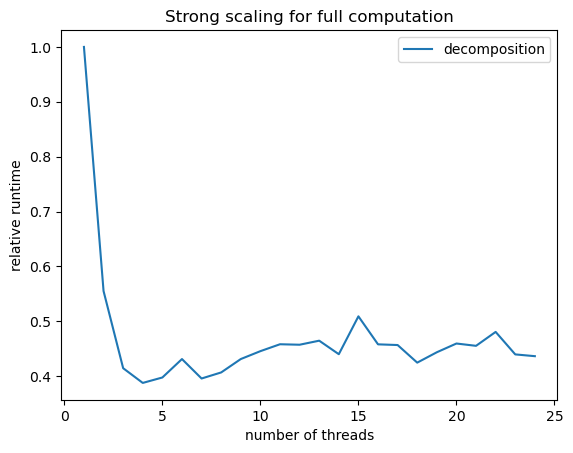

In [32]:
# plot the scaling of performance gains
import os
from time import perf_counter

thread_range = range(1, os.cpu_count() + 1)
run_time_cd = []
for num_threads in thread_range:
    run_time_cd.append(0)
    ensemble.processor.num_threads_full = num_threads
    #ensemble_ce.processor.num_threads_full = num_threads
    for _ in range(1000):
        start = perf_counter()
        ensemble.compute_feature_vector(occu)
        run_time_cd[-1] += perf_counter() - start

        #start = perf_counter()
        #ensemble_ce.compute_feature_vector(occu)
        #run_time_ce[-1] += perf_counter() - start

run_time_cd = np.array(run_time_cd)

import matplotlib.pyplot as plt
plt.plot(thread_range, run_time_cd/run_time_cd[0], label='CD')
plt.title("Strong scaling for full computation")
plt.ylabel("relative runtime")
plt.xlabel("number of threads")
plt.legend(["decomposition", "expansion"])
plt.show()

In [39]:
# run 1M iterations
# since this is the first run, the initial occupancy must be supplied
sampler.run(
    1000000,
    initial_occupancies=init_occu,
    thin_by=100, # thin_by will save every 100th sample only
    progress=True
) # progress will show progress bar

Sampling 1 chain(s) from a cell with 4096 sites: 100%|██████████| 1000000/1000000 [00:43<00:00, 23121.32it/s]


In [40]:
# print the number of being threads used
print(f"The cluster_subspace is set to use {ensemble.processor.cluster_subspace.num_threads} openmp threads for full computations.")
print(f"The processor is set to use {ensemble.processor.num_threads_full} openmp threads for full computations.")
print(f"The processor is set to use {ensemble.processor.num_threads} openmp threads to compute local changes.")

The cluster_subspace is set to use 2 openmp threads for full computations.
The processor is set to use 2 openmp threads for full computations.
The processor is set to use 2 openmp threads to compute local changes.


In [41]:
# Samples are saved in a sample container
samples = sampler.samples

print(f'Fraction of successful steps (efficiency) {sampler.efficiency()}')
print(f'The last step energy is {samples.get_energies()[-1]} eV')
print(f'The minimum energy in trajectory is {samples.get_minimum_energy()} eV')

# You can get the minimum energy structure and current structure
# by using the ensemble processor
curr_s = ensemble.processor.structure_from_occupancy(samples.get_occupancies()[-1])
min_s = ensemble.processor.structure_from_occupancy(samples.get_minimum_energy_occupancy())

Fraction of successful steps (efficiency) 0.0111
The last step energy is -14129334795916.953 eV
The minimum energy in trajectory is -14129334795917.068 eV


#### 4.1) Continuing or resetting the MC trajectory
You can always continue running more iterations from where the trajectory left off by calling `run` again.
You can also reset to the initial state. (we will skip this step for now so we can show results from the run above.

In [42]:
# You can continue the MC trajectory simmply by calling run again
# it is recommended to use the same thin_by used before
#sampler.run(10000, thin_by=100)  # this will append new data

# If you want to start from scratch
#sampler.clear_samples()  # this will delete data, and reset the ensemble to its initial state
# Now you can start a fresh run
#sampler.run(1000000,
#             initial_occupancies=init_occu,
#             thin_by=100, # thin_by will save every 100th sample only
#             progress=True) # progress will show progress bar

### 5) Check convergence of MC sampling
Find the minimum number of samples required to discard for equilibration while converging the energy

[-1.24250888e+10 -1.80413830e+10 -4.61580595e+10 ... -1.41293348e+13
 -1.41293348e+13 -1.41293348e+13]


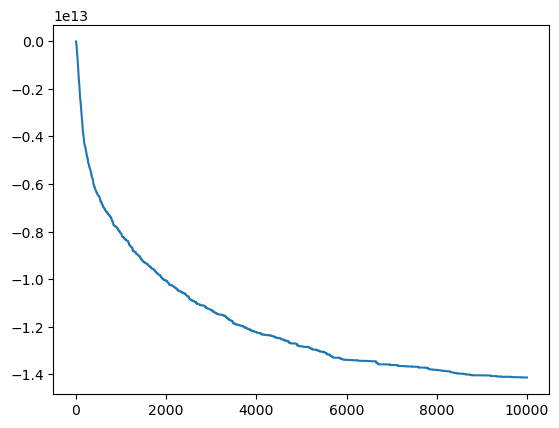

In [43]:
#from smol.moca.analysis.convergence import check_property_converged, determine_discard_number

energies = samples.get_energies()
# 100 as an initial guess for amount to discard
#opt_discard = determine_discard_number(property_array=energies, init_discard=100, verbose=True)
#converged = check_property_converged(energies[opt_discard:])
#print(f'Is the energy converged after discarding the first {opt_discard} samples?', converged)
print(energies)

# let's plot the energy trajectories over time 

import matplotlib.pyplot as plt
runs = np.arange(len(energies))
plt.plot(runs, energies)

### 6) Look at trajectory samples and averages
We can look at the sampled energies, the average and variance directly from the class properties.

For further analysis samples are stored as a list of dictionaries for each sampled step in the `CanonicalEnsemble.data` attribute.
In the `CanonicalEnsemble` class only the energy and occupancy string of each sample are saved.

In [44]:
# Set 100 samples for burn-in, as determined in 5)
discard = 100 # this is in terms of samples so it would be discard*thin_by steps
print(f'A total of {len(samples)} samples taken.')
print(f'A total of {len(samples.get_energies(discard=discard))} samples used for production.')
print(f'The average energy is {samples.mean_energy(discard=discard)} eV')
print(f'The energy variance is {samples.energy_variance(discard=discard)} eV^2')
print(f'The sampling efficiency (acceptance rate) is approximately {samples.sampling_efficiency(discard=discard)}')

A total of 10000 samples taken.
A total of 9900 samples used for production.
The average energy is -11945216369429.943 eV
The energy variance is 5.56122016143897e+24 eV^2
The sampling efficiency (acceptance rate) is approximately 0.008282828282828282


In [45]:
#write these to cif files
from pymatgen.io.cif import CifWriter
structure_path = '/home/myless/Packages/structure_maker/Visualization/Structures'

initial_structure = samples.get_sampled_structures(indices=[0])[0]
print(initial_structure)

# write the initial structure to a CIF file
cif = CifWriter(initial_structure)
total_initial_path = os.path.join(structure_path, 'big_big_initial_structure.cif')
cif.write_file(total_initial_path)

# print the last structure 
final_structure = samples.get_sampled_structures(indices=[-1])[0]
print(final_structure)

# write the final structure to a CIF file
cif = CifWriter(final_structure)
total_final_path = os.path.join(structure_path, 'big_big_final_structure.cif')
cif.write_file(total_final_path)


Full Formula (Zr84 Ti210 V3292 Cr378 W132)
Reduced Formula: Zr42Ti105V1646(Cr63W22)3
abc   :  41.707783  41.707783  41.707783
angles: 109.471221 109.471221 109.471221
pbc   :       True       True       True
Sites (4096)
   #  SP         a       b       c
----  ----  ------  ------  ------
   0  Cr    0       0       0
   1  V     0       0       0.0625
   2  V     0       0       0.125
   3  V     0       0       0.1875
   4  V     0       0       0.25
   5  V     0       0       0.3125
   6  V     0       0       0.375
   7  W     0       0       0.4375
   8  V     0       0       0.5
   9  V     0       0       0.5625
  10  V     0       0       0.625
  11  V     0       0       0.6875
  12  V     0       0       0.75
  13  V     0       0       0.8125
  14  V     0       0       0.875
  15  V     0       0       0.9375
  16  V     0       0.0625  0
  17  V     0       0.0625  0.0625
  18  Cr    0       0.0625  0.125
  19  W     0       0.0625  0.1875
  20  V     0       0.0625  0.2

### Save your work
The `Sampler` class does and can not be saved since it does not really have any computed values. However the `SampleContainter` where the MC samples are recorded can be saved.
You can use the same `save_work` convenience function to save your work.

You can also save the `SampleContainer` as an hdf5 file. You will need `h5py` installed.